# <center> 2. Валидация данных. Методы валидации

В предыдущих модулях по машинному обучению тот набор данных, на котором мы проверяли качество построенной модели, мы называли тестовым набором данных (testing data). Мы заранее выделяли этот набор данных для того, чтобы рассчитать финальную метрику модели и сделать вывод о том, устраивает ли нас качество моделирования. Такой подход называется двухкомпонентным.

В больших Data Science-проектах используется не два, а три набора данных: в дополнение к тренировочному и тестовому набору данных выделяется валидационный набор (validation data). Этот набор используется для промежуточного контроля качества модели и настройки внешних параметров, которые задаёт исследователь при построении модели. Такой подход называется трёхкомпонентным.

Обучающая (тренировочная) — набор данных, который используется в процессе обучения модели (подбора внутренних параметров, например коэффициентов линейной регрессии или предикатов в деревьях решений).
Валидационная (проверочная) — набор данных, на котором мы оцениваем промежуточные результаты обучения. Основная цель создания такого набора данных — отслеживание переобучения. На валидационной выборке мы производим подбор гиперпараметров — внешних параметров модели, например коэффициентов регуляризации, максимальной глубины дерева, количества деревьев в случайном лесу и т. д.
Тестовая (контрольная) — набор данных, который имитирует работу модели в реальных условиях после подбора всех параметров. С помощью этого набора осуществляется окончательная проверка качества. Главное условие для тестовой выборки — она должна быть независимой от обучающей.

Процесс проверки предсказательной способности модели машинного обучения называется валидацией.

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
water_data = pd.read_csv('/home/aleksandr/Документы/GitHub/data/ML5/water_potability.csv')
water_data.head()
# Целевой признак — Potability (пригодность для питья): 1 — вода пригодна, 0 — вода не пригодна.

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [3]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [4]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

### HOLD-OUT метод валидации

Метод hold-out (отложенная выборка) нам уже знаком. Это самый простой, но в то же время популярный метод.
Его идея состоит в том, что для проверки модели мы просто случайным образом разбиваем весь набор данных на обучающую, валидационную и тестовую выборки (последняя — по желанию).
ПРЕИМУЩЕСТВА И НЕДОСТАТКИ HOLD-OUT:
+ Очень простой и понятный.
+ Чаще всего применяется на больших датасетов, так как требует значительно меньше вычислительных мощностей, чем другие методы.
- разбиение производится случайным образом и оценка в этом методе зависит от того, какие наблюдения попали в набор для валидации. Это плохо, так как возможна ситуация, когда распределение целевого признака в тренировочной, валидационной (и тестовой) выборках может значительно различаться и оценка качества может быть необъективной.

Основные параметры train_test_split():
- *arrays — порядковый аргумент с переменным количеством. Набор массивов (это могут быть списки, numpy-массивы, DataFrame), которые подлежат разбиению.
- test_size — размер тестовой (валидационной) выборки. Может быть указан в долях. Определяется автоматически, если параметр test_size передан как 1-train_size.
- train_size — размер тренировочной выборки. Может быть указан в долях. Определяется автоматически, если параметр test_size передан как 1-test_size.
- random_state — число, на основе которого производится генерация случайных чисел.
- shuffle — параметр, указывающий, стоит ли перемешивать выборку перед разбиением (по умолчанию True).
- stratify — стратифицированное разбиение (о нём мы поговорим в юните по дисбалансу выборки).

In [8]:
# двухкомпонентный подход 
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


In [9]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


In [10]:
# трёхкомпонентный подход 
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


### K-FOLD

Метод k-fold более известен как кросс-валидация (cross validation), или перекрёстный контроль.

алгоритм кросс-валидации:

Разбить исходную выборку на k частей — фолдов (fold).
Повторять k раз:
1. Обучить модель на k-1 частях. Назовём их тренировочными фолдами (training fold). 
2. Произвести оценку качества (вычислить метрику) на оставшейся части. Назовем её валидационным фолдом (validation fold).
3. Усреднить значения метрики на валидационных фолдах.

Чем больше , тем больше моделей будут обучаться, тем объективнее будет оценка качества, однако тем больше времени займёт процесс валидации.

ПРЕИМУЩЕСТВА И НЕДОСТАТКИ K-FOLD
+ Подход позволяет получить более устойчивую к выбросам оценку качества модели, так как модель обучается на нескольких независимых наборах данных.
+ Значения метрик получаются более объективными, ведь мы обучаем одну модель k раз — у нас получается k независимых друг от друга значений метрики.
- Подход предусматривает, что мы обучаем одну и ту же модель k раз, что, очевидно, плохо сказывается на производительности. Если модель обучается довольно медленно (например, сложная нейронная сеть), то валидация может занять очень много времени.

Основные параметры инициализатора KFold:
- n_split —  число фолдов (число  из метода k-fold). По умолчанию — 5.
- shuffle — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — False.
- random_state — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.

In [15]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))
    
print(train_metrics)
print(val_metrics)

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


In [16]:
# Для агрегированной оценки рассчитаем среднее значение метрик:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


приведённый выше код можно значительно сократить, если использовать специальную функцию для кросс-валидации — cross_validate() из модуля model_selection

Основные параметры функции cross_validate():

- estimator — модель, качество которой будет проверяться на кросс-валидации.
- X — матрица наблюдений.
- y — вектор-столбец правильных ответов.
- cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
- scoring — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и другие; полный список — в документации к функции).
- return_train_score — параметр, указывающий стоит ли возвращать значения метрики, полученных на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.

Функция возвращает словарь со следующими ключами:
- fit_time — время обучения модели на каждой итерации кросс-валидации;
- score_time — время вычисления метрик на каждой итерации кросс-валидации;
- test_score — значения метрик на валидационных фолдах;
- train_score — значения метрик на тренировочных фолдах.

In [17]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.02819157, 0.02583241, 0.02392602, 0.02316642, 0.02654958]),
 'score_time': array([0.00243735, 0.0024333 , 0.00237632, 0.00238991, 0.00231504]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

### LEAVE-ONE-OUT

Метод leave-one-out (отложенный пример), или поэлементная кросс-валидация — это частный случай кросс-валидации (k-fold), когда размер k равняется размеру всей выборки k=n, где n — количество примеров (строк в таблице).

Алгоритм метода:
1. Повторять n раз:
- Выбрать один случайный пример для валидации.
- Обучить модель на всех оставшихся n-1 примерах.
- Произвести оценку качества (вычислить метрику) на отложенном примере.
2. Усреднить значение метрик на всех примерах.

ПРЕИМУЩЕСТВА И НЕДОСТАТКИ LEAVE-ONE-OUT
+ Идеально подходит для небольших датасетов (менее 100 примеров).
+ Поскольку все доступные данные используются как для обучения, так и для валидации, значения метрик наиболее объективны и надёжны.
- Метод не подходит для оценки качества модели на больших наборах данных, поскольку становится очень ресурсозатратным.

In [18]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


# <center> 3. Дисбаланс выборки

Несбалансированный набор данных (unbalanced dataset) — это выборка, в которой количества примеров каждого из классов значительно отличаются.
При этом: класс большинства называется мажоритарным (majority) классом; класс меньшинства называется миноритарным (minority) классом.

Типичные примеры задач, в которых исследователи чаще всего сталкиваются с дисбалансом выборки: 
- Обнаружение мошенничества.
- Обнаружение оттока клиентов.
- Распознавание лиц.

Проблемы, которые могут возникнуть из-за несбалансированной выборки:
- При разбиении несбалансированной выборки на тренировочную/валидационную/тестовую увеличивается шанс попадания в одну из них объектов только одного класса, из-за чего оценка качества модели может быть необъективной.
- Нельзя использовать метрики, не учитывающие размеры классов, такие как accuracy. Данную проблему мы обсуждали, когда знакомились с метриками классификации.
- Стандартные методы ML, такие как дерево решений и логистическая регрессия, имеют тенденцию игнорировать класс меньшинства.

0    0.60989
1    0.39011
Name: Potability, dtype: float64

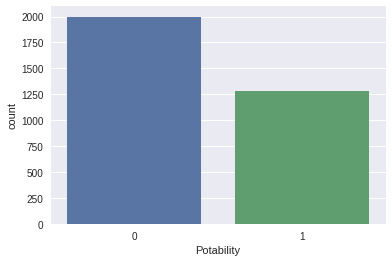

In [5]:
# Посмотрим на соотношения классов внутри датасета:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

### СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

In [39]:
# hold-out без стратификации:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


In [40]:
# hold-out co стратификацией:
X_train, X_valid, y_train, y_valid= model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


In [9]:
# стратифицированное k-fold-разбиение на три фолда
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


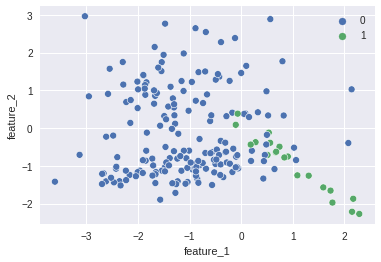

In [11]:
# Задание 3.3
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);

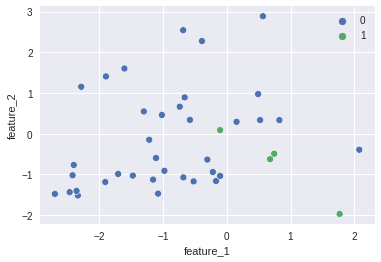

In [12]:
X_train, X_valid, y_train, y_valid= model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y_valid);

### ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

используются метрики, которые концентрируются на каждом из классов отдельно, — это знакомые нам из модуля по классификации precision, recall и F1-score.

In [41]:
# Давайте на примере посмотрим, насколько важен выбор метрики в случае дисбаланса выборки.

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



Precision для класса 1 составляет 0.81, то есть из всех образцов воды, причисленных моделью к классу пригодных для питья, 81 % действительно являются таковыми.
Recall для класса 1 составляет 0.55, то есть из всех образцов воды пригодными для питья являются лишь 55 %, при этом остальные 45 % модель посчитала непригодными для питья.
F1-мера — среднее гармоническое между precision и recall — составила 0.65 для класса 1 и 0.83 — для класса 0. Разница довольно далека от нуля, а значит построенная нами модель больше контролируется на образцах воды, непригодных для питья, и обладает плохой различающей способностью.

In [25]:
# Задание 3.5. используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.

log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train, y_train)
y_valid_pred = log_reg.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



In [13]:
# Задание 3.6
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

#plot_probabilities_2d(X, y, log_reg)

### ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

Существует несколько способов уменьшить влияние дисбаланса на обучение модели:
1. Взвешивание объектов. В функцию ошибки добавляется штраф, прямо пропорциональный количеству объектов каждого класса. Это очень похоже на регуляризацию, которую мы изучали ранее.
2. Выбор порога вероятности. Этот подход мы с вами тоже уже использовали ранее. Он заключается в том, что мы подбираем такой порог вероятности (по умолчанию он равен 0.5 во всех моделях), при котором на валидационной выборке максимизируется целевая метрика (например, F1-score).
3. Сэмплирование (sampling) — перебалансировка выборки искусственным путём:
- oversampling — искусственное увеличение количества объектов миноритарного класса;
- undersampling — сокращение количества объектов мажоритарного класса.
Здесь могут использоваться алгоритмы генерации искусственных данных, такие как NearMiss, SMOTE (Synthetic Minority Oversampling Techniques) и ADASYN (Adaptive Synthetic).

#### 1.ВЗВЕШИВАНИЕ ОБЪЕКТОВ

Большинство моделей, реализованных в sklearn, имеют параметр class_weight — веса классов
class weight (majority) = 1
а веса объектов малочисленного (миноритарного) класса вычисляются по следующей формуле:
class weight (minority) = 1 + Nminority/Nmajority
где N - число — объектов в миноритарном и мажоритарном классах соответственно. 

In [32]:
# Посмотрим на реализацию на примере дерева решений:
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.63      0.76      0.69       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



In [35]:
# Задание 3.7 используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.
log_reg = linear_model.LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)
y_valid_pred = log_reg.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



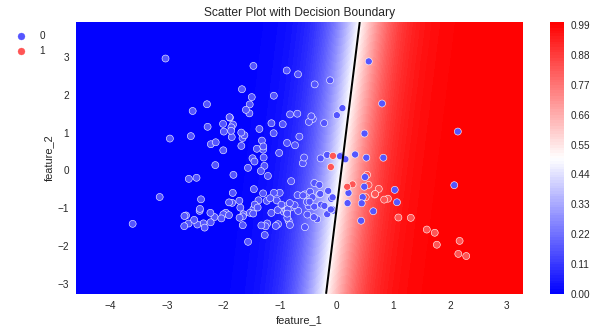

In [36]:
# Задание 3.8
plot_probabilities_2d(X, y, log_reg)

#### 2. ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ

PR-кривая (precision-recall curve) — это график зависимости precision от recall при различных значениях порога вероятности.
Для построения данного графика мы берём множество различных порогов вероятности (0.1, 0.15, 0.2, …1) и вычисляем метрики precision и recall при разных порогах вероятности.
Что нам даёт такая кривая?
1. Во-первых, PR-кривая — это графическая метрика качества модели, она комплексно отражает и precision, и recall одновременно (как F1-мера) и особенно хороша в условиях дисбаланса классов. Качество определяется площадью (PR AUC) под кривой: чем ближе значение площади к 1, тем лучше модель. Если площадь под PR-кривой меньше 0.5, модель считается очень слабой 
2. Во-вторых, с помощью PR-кривой удобно находить оптимальный порог вероятности. Главное — определиться с критерием этой оптимальности. На кривой мы можем найти такие точки, в которых наблюдается наилучшее значение precision или recall или среднее геометрическое между ними (-score). 

In [45]:
# Пусть мы хотим найти такой порог вероятности, при котором наблюдается максимум метрики F1 для класса 1
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
y_cv_proba_pred

array([[0.        , 1.        ],
       [0.24561404, 0.75438596],
       [1.        , 0.        ],
       ...,
       [0.60621762, 0.39378238],
       [1.        , 0.        ],
       [0.03030303, 0.96969697]])

In [46]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Best threshold = 0.33, F1-Score = 0.69


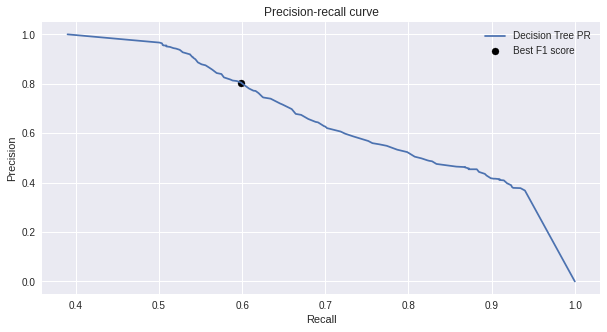

In [47]:
#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума c помощью функции argmax() из модуля numpy — она возвращает индекс максимального элемента массива.
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [49]:
# Сделаем предсказание классов с таким порогом для всех объектов из отложенной валидационной выборки 
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
threshold_opt = 0.33
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



In [50]:
# Чтобы вычислить площадь под PR-кривой, используется функция auc() из модуля metrics библиотеки sklearn. 
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.79


### 3. СЭМПЛИРОВАНИЕ

Идея пересэмплирование (oversampling) очень проста: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество.
специальные алгоритмы генерации искусственных данных. Самый популярный из таких алгоритмов — алгоритм SMOTE (Synthetic Minority Oversampling Techniques).

В основе алгоритма лежит идея генерации некоторого количества искусственных наблюдений, которые были бы «похожи» на наблюдения, имеющиеся в миноритарном классе, но при этом не дублировали их.

In [5]:
# !pip install imbalanced-learn
# !conda install -c conda-forge imbalanced-learn
# возможно стоит обновить пакеты Anaconda: conda update conda
from imblearn.over_sampling import SMOTE

In [8]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (160, 2)
Class balance before oversampling: 
0    144
1     16
dtype: int64
----------------------------------------
Train shape after oversampling: (288, 2)
Class balance after oversampling: 
0    144
1    144
dtype: int64


In [ ]:
# Попробуем обучить нашу модель на сгенерированных обучающих данных и сделать предсказание на валидационной выборке
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

In [15]:
# Задание 3.11 используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.
sm = SMOTE(random_state=42)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)
log_reg_smote = linear_model.LogisticRegression()
log_reg_smote.fit(X_train_s, y_train_s)
y_valid_pred = log_reg_smote.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



/home/aleksandr/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/tmp/ipykernel_24557/403280231.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


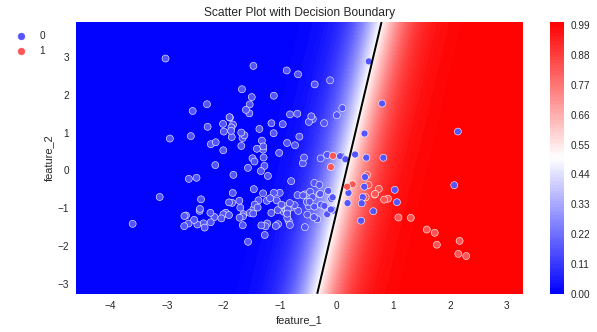

In [18]:
plot_probabilities_2d(X, y, log_reg_smote)

На самом деле плохая различающая способность может быть связана не только с дисбалансом выборки. На качество моделирования влияют и другие факторы:
- Сложность модели. Выбранная нами модель дерева решений является довольно простым классификатором. Имеет смысл задуматься над применением более сложных методов, например случайного леса.
- Недостаток информации. Вполне возможно, признаков, описывающих химический состав воды, попросту недостаточно, чтобы точно сказать, пригодна ли она для питья.
- Качество данных. В представленных данных возможно наличие зашумлённой информации — выбросов и аномальных образцов воды.

# <center> 4. Недообучение и переобучение. Утечка данных

Важной характеристикой алгоритма машинного обучения является его обобщающая способность — способность использовать знания, полученные при обучении, на новых данных.
Обобщающая способность часто страдает из-за двух основных проблем машинного обучения: overfitting (переобучение) и underfitting (недообучение).

Переобучение (overfitting) — это проблема, при которой модель чувствительна к незначительным колебаниям в данных в процессе обучения. По сути, такая модель работает намного лучше с обучающими данными, чем с новыми. Она была чрезмерно натренирована на обнаружение уникальных характеристик обучающего набора данных, которые не являются общими закономерностями.

Недообучение (underfitting) — это проблема, при которой алгоритм недостаточно хорошо изучил данные и пропускает важные зависимости между признаками. В случае недообучения мы даже на обучающих данных не можем достичь приемлемых оценок для модели.

Попытка бороться с одной проблемой может привести к возникновению другой, поэтому возникает дилемма смещения-разброса (bias-variance tradeoff).

Смещение (bias) — это математическое ожидание (обозначено далее как E) разности между истинным ответом и ответом, выданным моделью. То есть это ожидаемая ошибка модели. Bias — это теоретическая характеристика недообучения.
bias(y^) = E[(y-y^)]

Разброс (variance) — это вариативность ошибки, то, насколько ошибка будет отличаться, если обучать модель на разных наборах данных. Математически это дисперсия (разброс) ответов модели (обозначено далее как Var). Variance — это теоретическая характеристика переобучения.
variance(y^) = Var[(y-y^)]

### КАК ОБНАРУЖИТЬ ПЕРЕОБУЧЕНИЕ

Основные способы отследить переобучение:
- hold-out-разбиение,
- k-fold-валидация и leave-one-out-валидация,
- кривые обучения (learning curves).

In [5]:
# Сначала проверим модель на переобучение с помощью отложенной (hold-out) выборки.

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))

Train F1 score: 1.00
Valid F1 score: 0.67


Это типичная картина переобучения: модель дерева решений полностью адаптировалась под обучающий набор данных, но не нашла общих закономерностей, 

In [6]:
# Проверим гипотезу о наличии переобучения у нашего дерева с помощью кросс-валидации k-fold
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.04148626, 0.03623867, 0.04042912, 0.03359914, 0.03434825]),
 'score_time': array([0.00425386, 0.00307298, 0.00282335, 0.00305223, 0.00277448]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [7]:
# Подсчитаем среднее значение F1-score на выборках:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


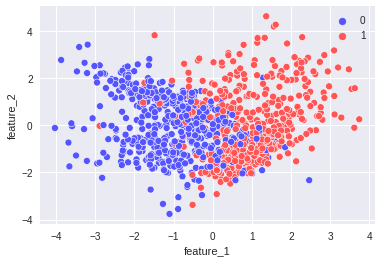

In [8]:
# Задание 4.3
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');

In [11]:
# Задание 4.3 продолжение
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

model_bad = tree.DecisionTreeClassifier(max_depth=10)
model_bad.fit(X_train, y_train)
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)

print('Train accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid accuracy score: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

Train accuracy score: 0.98
Valid accuracy score: 0.81


/home/aleksandr/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_4618/4144583157.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


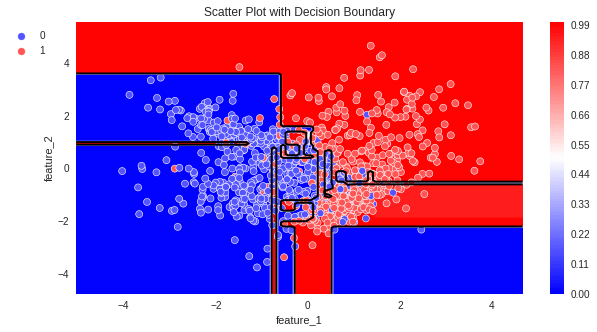

In [14]:
# Задание 4.4
plot_probabilities_2d(X, y, model_bad)

Train accuracy: 0.88
Valid accuracy: 0.85


/home/aleksandr/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_4618/4144583157.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


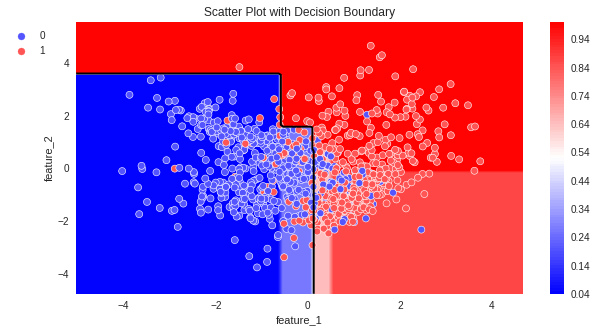

In [16]:
# Задание 4.6 изменение глубины max_depth=3
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)
print('Train accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))
# Задание 4.7
plot_probabilities_2d(X, y, clf)

### УТЕЧКА ДАННЫХ

Утечка данных (data leak) — это ситуация, в которой данные, используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной.
1. ОЧЕВИДНЫЕ СЛУЧАИ
- Включение целевой переменной, которую мы пытаемся предсказать, в качестве фактора, что полностью уничтожает цель «прогнозирования». Это может быть сделано по ошибке, но важно убедиться, что целевая переменная отличается от признаков.
- Включение тестовых данных в данные по обучению модели, а затем использование этих же тестовых данных для оценки качества модели.
2. СКРЫТЫЕ СЛУЧАИ, ИЛИ GIVEAWAY-ПРИЗНАКИ
Giveaway — это признаки, которые раскрывают информацию о целевой переменной и не будут доступны после развёртывания модели в реальных условиях. Такие признаки необходимо удалять из данных перед построением модели.

КАК ОБНАРУЖИТЬ УТЕЧКУ ДАННЫХ
- Читайте описание признаков. Из описания признаков всегда можно узнать полезную информацию и обнаружить утечку с помощью банальной логики. Если вы предсказываете цену товара, а в вашем наборе данных есть признак цены этого товара со скидкой, очевидно, что данный признак стоит удалить из обучающего набора данных.

- Проверяйте корреляции с целевым признаком. В процессе разведывательного анализа вы можете обнаружить признаки, которые очень сильно коррелируют с целевой переменной. Конечно, такая корреляция может быть естественной и не сопровождаться утечкой, например корреляция между количеством комнат в квартире и её ценой. Однако высокая степень корреляции между налоговой выплатой за продажу и ценой квартиры — это яркий пример утечки.

- Относитесь скептически к подозрительно высокому качеству моделей. При построении модели вас может насторожить слишком высокое качество даже самых простых моделей, которого в реальных условиях достичь не удалось бы. Это может быть сигналом о наличии утечки данных.

Поэтому для начала старайтесь строить baseline — простые модели машинного обучения, такие как логистическая регрессия.

# <center> 5. Кривая обучения

валидационная кривая (validation curve) позволяет увидеть, как изменяется метрика в зависимости от значения внешнего параметра.
кривые обучения (learning curve) позволяют легко определять наличие переобучения и недообучения, визуально сравнивать модели собой и увидеть, как качество модели зависит от добавления новых данных.

### ИДЕЯ КРИВОЙ ОБУЧЕНИЯ

Кривая обучения (learning curve) — это график зависимости некоторой метрики на обучающем (валидационном) наборе данных от количества объектов, которые участвуют в обучении модели.

Что нам дают такие кривые?
1. Основное назначение кривых обучения — мониторинг изменения метрики в процессе поступления новых данных. Благодаря этому мы можем найти такой размер данных, начиная с которого обогащение набора данных новыми наблюдениями не приносит значительного эффекта.
2. Благодаря кривым обучения мы можем отслеживать недообучение и переобучение модели.
3. Кривые обучения позволяют визуально сравнить качество различных моделей.

### ПОСТРОЕНИЕ КРИВОЙ ОБУЧЕНИЯ

Для вычисления точек для построения кривых обучения в модуле model_selection библиотеки sklearn есть функция learning_curve(). https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

Основные параметры функции learning_curve():
- estimator — модель, качество которой будет проверяться на кросс-валидации.
- X — матрица наблюдений.
- y — вектор-столбец правильных ответов.
- train_sizes — относительное (долевое) или абсолютное количество обучающих примеров, которые будут использоваться для создания кривой обучения. Если dtype имеет значение float, он рассматривается как часть максимального размера обучающего набора (который определяется выбранным методом проверки), т. е. он должен быть в пределах (0, 1]. По умолчанию используется список [0.1, 0.325, 0.55, 0.775, 1.0], то есть для построения кривой обучения используется пять точек. Первая точка кривой обучения строится по 10 % наблюдений из обучающего набора, вторая точка — по 32.5 % и так далее до тех пор, пока в построении модели не будет участвовать весь обучающий набор данных.
- cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация k-fold на пяти фолдах.
- scoring — название метрики в виде строки либо функция для её вычисления.

Если передать функции все необходимые параметры, она вернёт три массива:
- Список из размеров тренировочного набора (ось абсцисс кривой обучения).
- Матрица из метрик, полученных при разных размерах тренировочного набора во время кросс-валидации на тренировочных фолдах. В строках этой таблицы указаны списки метрик, соответствующие каждому размеру тренировочного набора данных, а внутри списков находятся сами метрики на кросс-валидации.
- Матрица из метрик, полученных при разных размерах тренировочного набора во время кросс-валидации на валидационных фолдах.

In [5]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    class_weight='balanced', 
    random_state=42, #генератор случайных чисел 
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Вычисляем координаты для построения кривой обучения
train_sizes, train_scores, valid_scores = model_selection.learning_curve(
    estimator = model, #модель
    X = X, #матрица наблюдений X
    y = y, #вектор ответов y
    cv = skf, #кросс-валидатор
    scoring = 'f1' #метрика
)
print('Train sizes: \n', train_sizes)
print('Train scores: \n', train_scores)
print('Valid scores: \n', valid_scores)

Train sizes: 
 [ 262  851 1441 2030 2620]
Train scores: 
 [[0.8        0.72727273 0.72727273 0.72727273 0.72727273]
 [0.76156584 0.82522523 0.8757764  0.8757764  0.8757764 ]
 [0.78546099 0.80108011 0.78497653 0.78183613 0.78183613]
 [0.75440806 0.74526573 0.72822528 0.76443265 0.75997384]
 [0.73336393 0.75992939 0.72322275 0.74051593 0.76085963]]
Valid scores: 
 [[0.62222222 0.2228739  0.18128655 0.25329815 0.28486647]
 [0.64528302 0.4978903  0.46031746 0.53831776 0.56928839]
 [0.59622642 0.60687023 0.60805861 0.56624319 0.60820896]
 [0.60903733 0.68641115 0.63859649 0.59344894 0.67407407]
 [0.61981982 0.6797153  0.66294227 0.61689587 0.71719039]]


In [6]:
# Для того чтобы вычислить среднюю кросс-валидационную метрику на каждом из наборов данных, рассчитаем среднее по столбцам матриц train_scores и valid_scores:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
 
print('Train k-fold f1 scores',  train_scores_mean)
print('Valid k-fold f1 scores',  valid_scores_mean)

Train k-fold f1 scores [0.74181818 0.84282405 0.78703798 0.75046111 0.74357833]
Valid k-fold f1 scores [0.31290946 0.54221938 0.59712148 0.6403136  0.65931273]


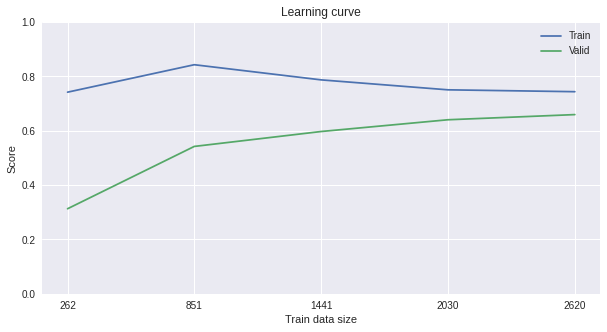

In [10]:
#Построим графики кривых обучения:
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим кривую обучения по метрикам на тренировочных фолдах
ax.plot(train_sizes, train_scores_mean, label='Train')
#Строим кривую обучения по метрикам на валидационных фолдах
ax.plot(train_sizes, valid_scores_mean, label='Valid')
#Даём название графику и подписи осям
ax.set_title('Learning curve')
ax.set_xlabel('Train data size')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси абсцисс
ax.xaxis.set_ticks(train_sizes)
#Устаналиваем диапазон оси ординат
ax.set_ylim(0, 1)
#Отображаем легенду
ax.legend();

In [8]:
# Для удобства дальнейшего использования описанных выше действий для построения кривой обучения давайте обернём их в функцию plot_learning_curve(). 
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring="f1",  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

Построим кривые обучения для нескольких моделей. Будем использовать следующие модели:
- логистическую регрессию,
- дерево решений с ограниченной максимальной глубиной и количеством объектов в листе,
- дерево решений без ограничений.

In [11]:
#Создаём список из моделей
models = [
    linear_model.LogisticRegression(
        max_iter=1000, #количество итераций на сходимость
        random_state=42, #генератор случайных чисел
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
]

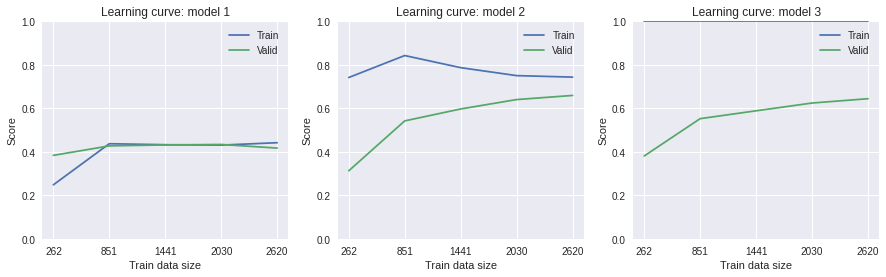

In [12]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + три координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X, y, skf, ax=axes[i], title=f'model {i+1}')

# <center> 6. Практика

In [13]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import ensemble #ансамбли

plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [14]:
shoppers_data = pd.read_csv('/home/aleksandr/Документы/GitHub/data/ML5/online_shoppers_intention.csv')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [15]:
print(shoppers_data.shape)

(12330, 18)


In [16]:
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [17]:
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации.

Non-fraud transactions: 84.53%
Fraud transactions: 15.47%


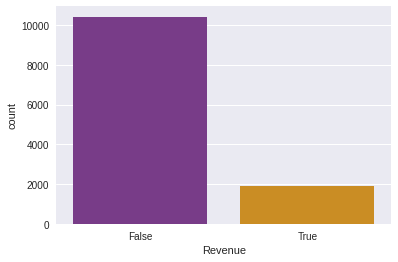

In [19]:
# В первую очередь посмотрим на соотношение классов в данных:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Non-fraud transactions: {:.2f}%'.format(class_percent[0]))
print('Fraud transactions: {:.2f}%'.format(class_percent[1]))

# имеем дело с несбалансированной выборкой

In [21]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

In [22]:
# Задание 6.2 Для начала позаботимся о создании отложенной тестовой выборки.
# Разделите выборку на тренировочную и тестовую в соотношении 80/20. Используйте разбиение, стратифицированное по целевому признаку.
# В качестве значения параметра random_state возьмите число 42.

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("Тренировочная выборка:", X_train.shape)
print("Тестовая выборка:", X_test.shape)

Тренировочная выборка: (9864, 28)
Тестовая выборка: (2466, 28)


In [23]:
# Задание 6.3 Создайте модель случайного леса. В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.
# Оцените качество такой модели с помощью кросс-валидации по пяти фолдам.
# Так как классы несбалансированы, используйте кросс-валидатор StratifiedKFold (перемешивать выборку не нужно).
# Для проведения кросс-валидации используйте функцию cross_validate(). Набор данных (параметры X, y) — тренировочная выборка (X_train, y_train). Метрика — F1-score.

#Создаём модель
rf_model = ensemble.RandomForestClassifier(random_state=42)
 
#Создаём кросс-валидатор StratifiedKFold
skf = model_selection.StratifiedKFold()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=rf_model, #модель
    X=X_train, 
    y=y_train, 
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 1.00
Valid k-fold mean accuracy: 0.65


Так как среднее значение F1-score на валидационных фолдах значительно ниже, чем на тренировочных, можно с уверенностью сказать, что модель является переобученной.

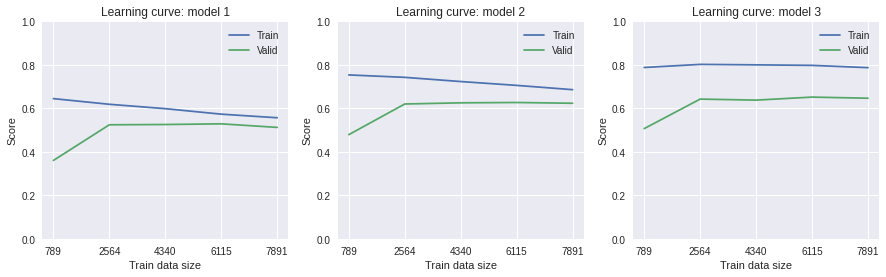

In [26]:
# Задание 6.5 Попробуем использовать несколько вариаций случайного леса и с помощью кривых обучения постараемся выбрать наилучшую из них.
# Создайте список из трёх следующих моделей: Случайный лес из деревьев максимальной глубины 5, 7 и 12.
# Для всех трёх моделей количество деревьев в лесу (n_estimators) возьмите равным 200, количество объектов в листе (min_samples_leaf) — 5.
# Параметр random_state = 42. Остальные параметры оставьте по умолчанию.
# воспользуйтесь функцией plot_learning_curve() и Постройте для каждой из моделей кривую обучения.
# для построения кривых используйте обучающий набор данных (X_train, y_train), стратифицированный кросс-валидатор на пяти фолдов (StratifiedKFold) и метрику F1-score.
# Остальные параметры функции learning_curve() оставьте по умолчанию.
# Из построенных кривых обучения сделайте вывод: какая глубина деревьев в лесу является оптимальной?

models = [
    ensemble.RandomForestClassifier(
        n_estimators=200, #число деревьев
        max_depth=5, #максимальная глубина дерева
        min_samples_leaf=5, #максимальная глубина дерева
        random_state=42 #генератор случайных чисел
    ),
    ensemble.RandomForestClassifier(
        n_estimators=200, #число деревьев
        max_depth=7, #максимальная глубина дерева
        min_samples_leaf=5, #максимальная глубина дерева
        random_state=42 #генератор случайных чисел
    ),
    ensemble.RandomForestClassifier(
        n_estimators=200, #число деревьев
        max_depth=12, #максимальная глубина дерева
        min_samples_leaf=5, #максимальная глубина дерева
        random_state=42 #генератор случайных чисел
    ),
]

#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + три координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X_train, y_train, skf, ax=axes[i], title=f'model {i+1}')

In [31]:
# Задание 6.6 Обучите случайный лес с выбранной в предыдущем задании оптимальной глубиной на тренировочной выборке.
# Сделайте предсказание меток классов и выведите отчёт о метриках классификации.

rf_model = ensemble.RandomForestClassifier(
    n_estimators=200, #число деревьев
    max_depth=7, #максимальная глубина дерева
    min_samples_leaf=5, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)

rf_model.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_test = rf_model.predict(X_test)
#Выводим отчет о метриках
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.91      0.98      0.94      2084
        True       0.79      0.49      0.60       382

    accuracy                           0.90      2466
   macro avg       0.85      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



Best threshold = 0.36, F1-Score = 0.69


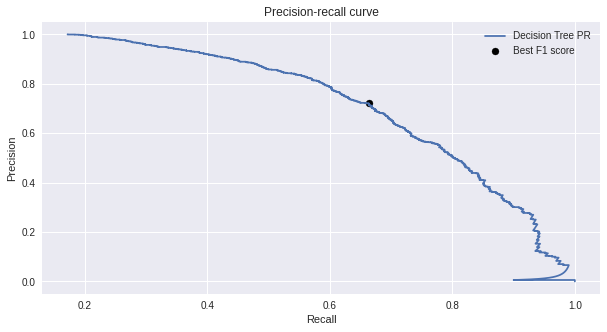

In [35]:
# Задание 6.7 Попробуем повысить качество распознавания посетителей, совершивших покупку. Используем метод подбора порога вероятности с помощью PR-кривой.
# Сделайте предсказание вероятностей принадлежности к пользователям, которые совершат покупку, на кросс-валидации на пяти фолдах.
# Используйте метод cross_val_predict().
# Для кросс-валидации используйте случайный лес с подобранной в задании 6.5 максимальной глубиной деревьев, параметры X, y — X_train, y_train.
# Постройте PR-кривую и отметьте на ней точку, в которой наблюдается максимум метрики F1 для посетителей, которые совершат покупку.
# Определите порог вероятности, соответствующий этой точке.

y_cv_proba_pred = model_selection.cross_val_predict(rf_model, X_train, y_train, cv=skf, method='predict_proba')

#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума c помощью функции argmax() из модуля numpy — она возвращает индекс максимального элемента массива.
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [42]:
# Задание 6.8 Сделайте предсказание классов объекта с определённым в предыдущем задании порогом вероятности. Выведите отчёт о метриках классификации.

threshold_opt = 0.36
y_valid_pred_proba = rf_model.predict_proba(X_test)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_valid_pred))

# Благодаря подбору порогу вероятности удалось повысить охват (recall) посетителей, которые совершат покупку, за счёт чего выросло значение F1-score. 

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2084
        True       0.66      0.69      0.67       382

    accuracy                           0.90      2466
   macro avg       0.80      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466



Для доп. обучения 
- Тактики работы в условиях дисбаланса https://dyakonov.org/2021/05/27/imbalance/
- Применение кривых обучения для диагностики overfitting и underfitting https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5